In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import seaborn as sns

## Load Data and Preprocess

In [67]:
import os
import shutil
import random
from tqdm import tqdm

data_dir = "./class"        # 👉 CHANGE: folder where your original class folders exist
output_dir = "./output_data"  # 👉 CHANGE: folder where train/ and val/ will be created
val_split = 0.2             # 👉 CHANGE: percentage of validation data (0.2 = 20%)

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Run the split only if it hasn't already been done
if not os.path.exists(train_dir):
    print("🔄 Splitting dataset...")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Loop through each class folder
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): 
            continue

        # Create corresponding train/ and val/ class folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)

        # Split index
        split_idx = int(len(images) * (1 - val_split))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy training images
        for img in tqdm(train_images, desc=f"Training - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        # Copy validation images
        for img in tqdm(val_images, desc=f"Validation - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

    print("Dataset split completed!")
else:
    print("Dataset already split — skipping this step.")


Dataset already split — skipping this step.


## Load Training Data

In [68]:
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    format="tf",
    verbose=True,
)


Found 3343 files belonging to 4 classes.


## Load Validation Data

In [69]:
validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    format="tf",
    verbose=True,
)


Found 838 files belonging to 4 classes.


In [70]:
train_set 
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [71]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot labels to class index
        if y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)

        # Convert probabilities to predicted class
        y_pred = tf.argmax(y_pred, axis=-1)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [72]:
# If your dataset is a tf.data.Dataset yielding (images, labels):
from collections import Counter
import numpy as np

def get_label_counts(ds, max_batches=200):
    counts = Counter()
    total = 0
    for i, (x,y) in enumerate(ds):
        if isinstance(y, tf.Tensor):
            # if one-hot -> convert to class index
            if y.ndim > 1 and y.shape[-1] > 1:
                labels = np.argmax(y.numpy(), axis=-1)
            else:
                labels = y.numpy()
        else:
            labels = np.array(y)
        counts.update(labels.flatten().tolist())
        total += labels.shape[0]
        if i >= max_batches-1:
            break
    return counts, total

train_counts, train_total = get_label_counts(train_set)
val_counts, val_total = get_label_counts(validation_set)

print("Train counts:", train_counts, " total:", train_total)
print("Val counts:  ", val_counts, " total:", val_total)


Train counts: Counter({1: 855, 3: 853, 0: 830, 2: 805})  total: 3343
Val counts:   Counter({1: 214, 3: 214, 0: 208, 2: 202})  total: 838


## MobileNetV3 Model

In [73]:
Input_shape = (224, 224, 3)

mobileNet_model = keras.applications.MobileNetV3Large(    
    input_shape=Input_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="MobileNetV3Large",
)


In [74]:
model_sequential = Sequential()

In [75]:
model_sequential.add(tf.keras.layers.InputLayer(input_shape=Input_shape))

In [76]:
model_sequential.add(mobileNet_model)

In [77]:
model_sequential.add(tf.keras.layers.Dense(units = 4, activation='softmax'))

In [82]:
Metrics = [
    'accuracy',
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    F1Score(name='f1')
]

model_sequential.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=Metrics
)   

In [83]:
model_sequential.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1000)           │     5,507,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,511,436 (21.02 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [84]:
for x, y in train_set.take(1):
    print("y shape:", y.shape)
    print("y example:", y[0])
    break


y shape: (32, 4)
y example: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


In [86]:
print(type(train_set))
print(type(validation_set))

training_history = model_sequential.fit(
   x = train_set, validation_data=validation_set, epochs=15)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Epoch 1/15


105/105 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8723 - cat_accuracy: 0.8723 - f1: 0.9629 - loss: 1.2997 - val_accuracy: 0.5406 - val_cat_accuracy: 0.5406 - val_f1: 0.8600 - val_loss: 1.3451
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9013 - cat_accuracy: 0.9013 - f1: 0.9710 - loss: 1.2790 - val_accuracy: 0.5334 - val_cat_accuracy: 0.5334 - val_f1: 0.9457 - val_loss: 1.3395
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9237 - cat_accuracy: 0.9237 - f1: 0.9779 - loss: 1.2586 - val_accuracy: 0.6384 - val_cat_accuracy: 0.6384 - val_f1: 0.9055 - val_loss: 1.3127
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9276 - cat_accuracy: 0.9276 - f1: 0.9764 - loss: 1.2401 - val_accuracy: 0.6885 - val_cat_accuracy: 0.6885 - val_f1: 0.9477 - val_loss: 1.2932
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9402 - cat_accuracy: 0.9402 - f1: 0.9815 - loss: 1.2213 - val_accuracy: 0.6933 - val_cat_accuracy: 0.6933 - 

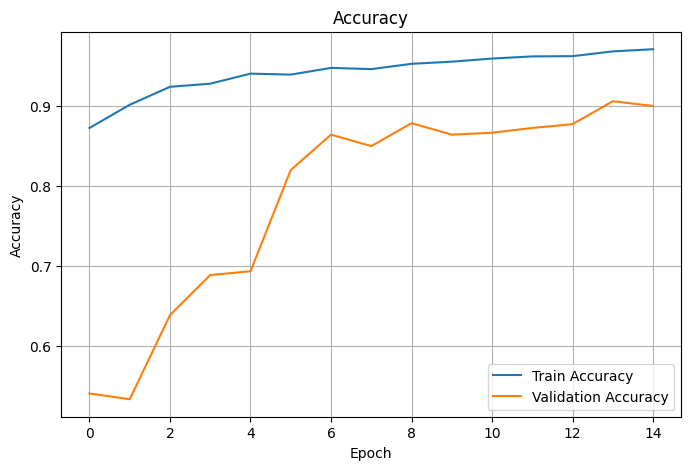

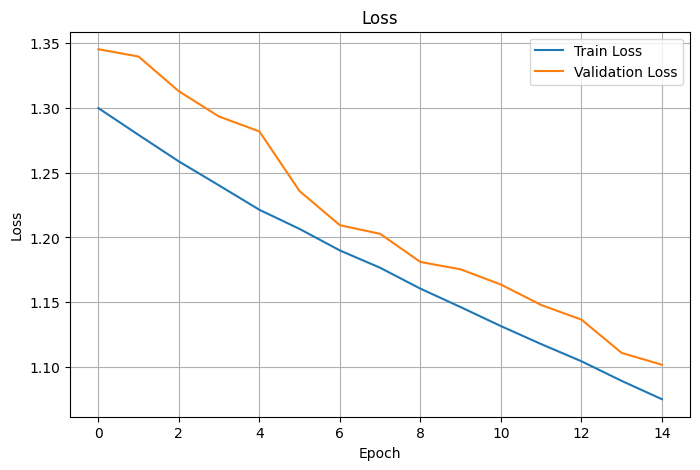

In [87]:
import matplotlib.pyplot as plt

history = training_history.history

# --- Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss ---
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Data Augmentation

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet_v2 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.map(lambda x, y: (preprocess_input(x), y))
validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))

train_set = train_set.prefetch(AUTOTUNE)
validation_set = validation_set.prefetch(AUTOTUNE)



## ResNet50 v2 Model

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,             
    weights="imagenet",            
    input_shape=(224, 224, 3),     
    pooling='avg'                  
)

# --- Minimal improvement: fine-tune last 40 layers ---
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

x = base_model.output

# --- Minimal improvement: stronger head ---
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [ ]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    F1Score(name='f1')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # better LR
    loss='categorical_crossentropy',
    metrics=metrics
)


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7
    )
]


In [ ]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6225 - f1: 0.5400 - loss: 0.9069 - precision: 0.8015 - recall: 0.4071 - val_accuracy: 0.5501 - val_f1: 0.1371 - val_loss: 1.1489 - val_precision: 0.7778 - val_recall: 0.0752 - learning_rate: 1.0000e-05
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7909 - f1: 0.7578 - loss: 0.5603 - precision: 0.8664 - recall: 0.6733 - val_accuracy: 0.7673 - val_f1: 0.6958 - val_loss: 0.6940 - val_precision: 0.8949 - val_recall: 0.5692 - learning_rate: 1.0000e-05
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8528 - f1: 0.8381 - loss: 0.4192 - precision: 0.8970 - recall: 0.7864 - val_accuracy: 0.8365 - val_f1: 0.8210 - val_loss: 0.4743 - val_precision: 0.8843 - val_recall: 0.7661 - learning_rate: 1.0000e-05
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8794 - f1: 0.8759 - loss: 0.3396 - precision: 0.9095 - recall: 0.8448 - val_accuracy: 0.8449 - val_f1: 0.8401 - val_loss: 0.41

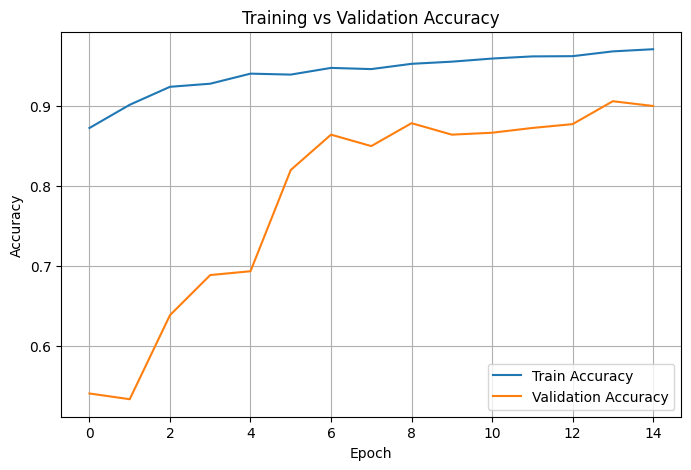

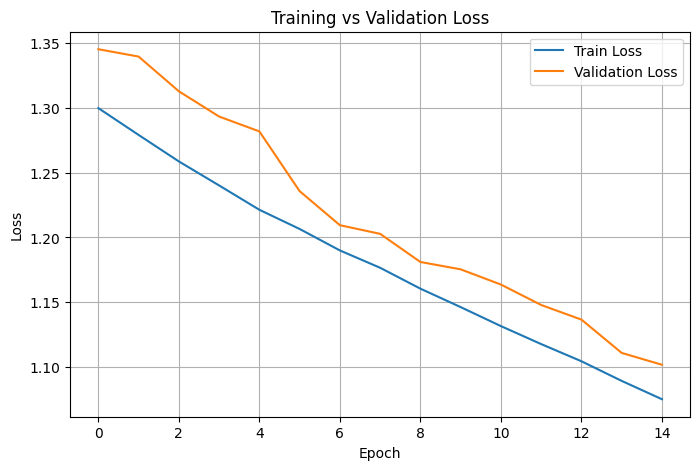

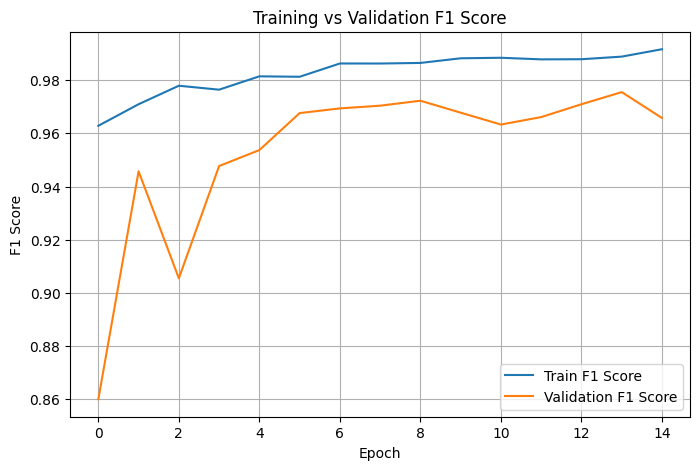

In [89]:
import matplotlib.pyplot as plt

# Get history dictionary
history_dict = history

# List of metrics to plot if present
possible_metrics = [
    ('accuracy', 'val_accuracy', 'Accuracy'),
    ('loss', 'val_loss', 'Loss'),
    ('precision', 'val_precision', 'Precision'),
    ('recall', 'val_recall', 'Recall'),
    ('f1', 'val_f1', 'F1 Score')
]

for train_key, val_key, title in possible_metrics:
    if train_key in history_dict and val_key in history_dict:
        
        plt.figure(figsize=(8, 5))
        plt.plot(history_dict[train_key], label=f"Train {title}")
        plt.plot(history_dict[val_key], label=f"Validation {title}")
        
        plt.title(f"Training vs Validation {title}")
        plt.xlabel("Epoch")
        plt.ylabel(title)
        plt.grid(True)
        plt.legend()
        plt.show()


In [91]:
model_sequential.save("./mobileNet_model.h5")
model_sequential.save('./mobileNet_model.keras')
model.save("./ResNet_model.h5")
model.save('./ResNet_model.keras')